# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 2 - Interpolacja
### Albert Gierlach

#### Zadanie 1 - Wielomiany interpolujące

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    // used for disabling collapsing big blocks of output ( like 3 charts in a row ;) )
    // so charts looks so beautiful
    return false; 
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib as mtplt
from matplotlib import pyplot as plt
from math import cos, pi, sin

mtplt.rcParams['figure.figsize'] = [20, 10] # plots size

In [3]:
def f(x):
    return 1/(1+x**2)


# a is the coefficients array, x is the point
def poly(x, a):
    y = 0
    for index, val in enumerate(a):
        y += val * (x**index)

    return y

In [4]:
def inter(n):
    plt.title("Podzial na {} wezlow".format(n))
    orig_x = np.linspace(-5, 5, 100)
    orig_draw, = plt.plot(orig_x, [f(x) for x in orig_x], label='f(x)')

    interval = np.linspace(-5, 5, n + 1)
    f_values = [f(x) for x in interval]
    vander = np.vander(interval, increasing=True)
    a = np.linalg.solve(vander, f_values)
    interpol_draw, = plt.plot(orig_x, [poly(x, a) for x in orig_x], label='Interpolated')

    # error
    error_draw, = plt.plot(orig_x, [abs(f(x) - poly(x, a)) for x in orig_x], label='Error')
    plt.legend(handles=[orig_draw, interpol_draw, error_draw])
    plt.show()

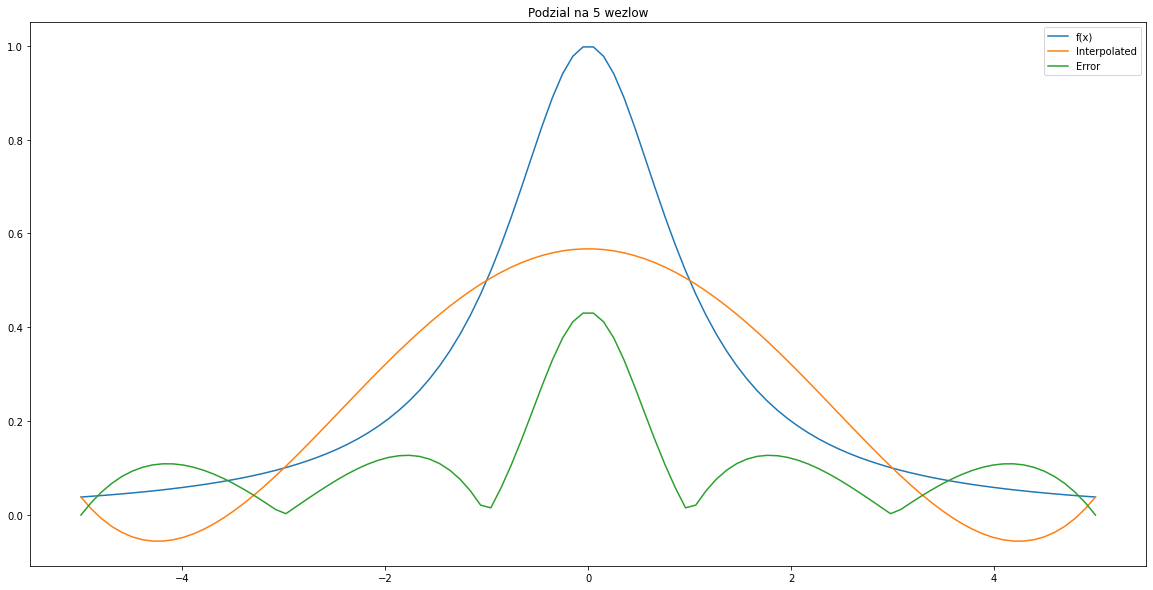

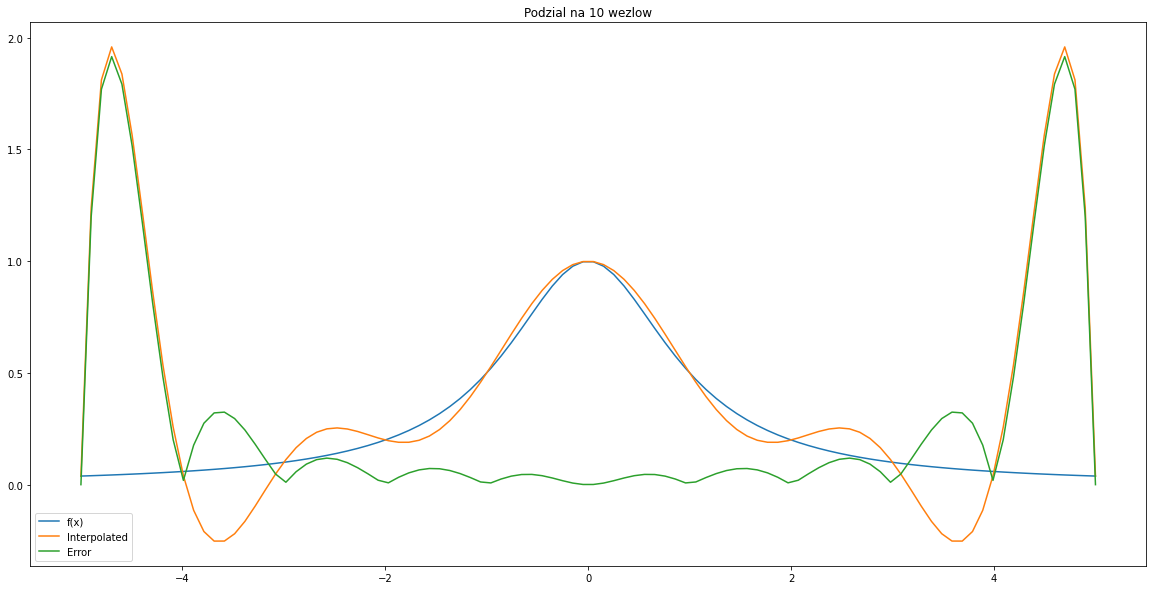

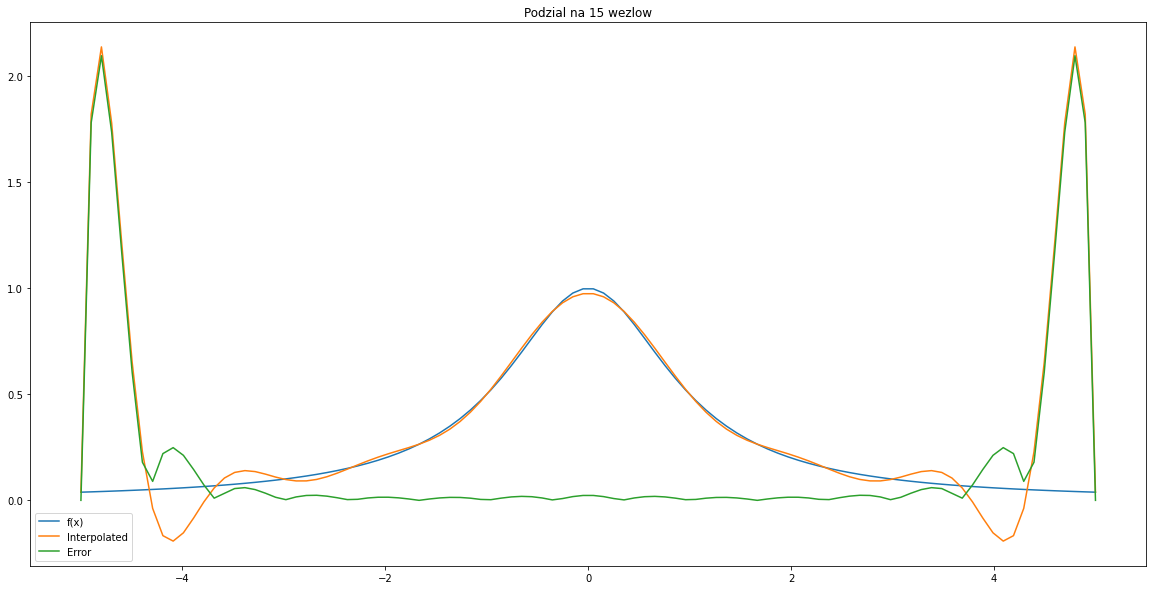

In [5]:
for n in [5, 10, 15]:
    inter(n)

Do wyliczenia współczynników wielomianu wykorzystałem macierz Vandermonde’a. \
**Wnioski**: Przy większej liczbie węzłów interpolacyjnych występuje efekt Rungego, polega on na pogorszeniu jakości interpolacji na końcach przedziału mimo zwiększenia liczby węzłów (co może wydawać się nielogiczne). Jest to typowe zjawisko przy interpolacji za pomocą wielomianów wysokiego stopnia.

#### Zadanie 2 - Wielomiany interpolujące

In [6]:
# Chebyshev nodes
def x_k(a, b, k, n):
    return (1/2 * (a + b)) + (1/2 * (b - a)) * cos((((2 * k) - 1) / (2 * n)) * pi)

In [7]:
def inter_2(n):
    a = -5
    b = 5
    plt.title("Podzial na {} wezlow".format(n))
    orig_x = np.linspace(-5, 5, 100)
    orig_draw, = plt.plot(orig_x, [f(x) for x in orig_x], label='f(x)')

    interval = [x_k(a, b, k, n) for k in range(1, n+1)]
    f_values = [f(x) for x in interval]
    vander = np.vander(interval, increasing=True)
    a = np.linalg.solve(vander, f_values)
    interpol_draw, = plt.plot(orig_x, [poly(x, a) for x in orig_x], label='Interpolated')

    # b) error
    error_draw, = plt.plot(orig_x, [abs(f(x) - poly(x, a)) for x in orig_x], label='Error')
    plt.legend(handles=[orig_draw, interpol_draw, error_draw])
    plt.show()

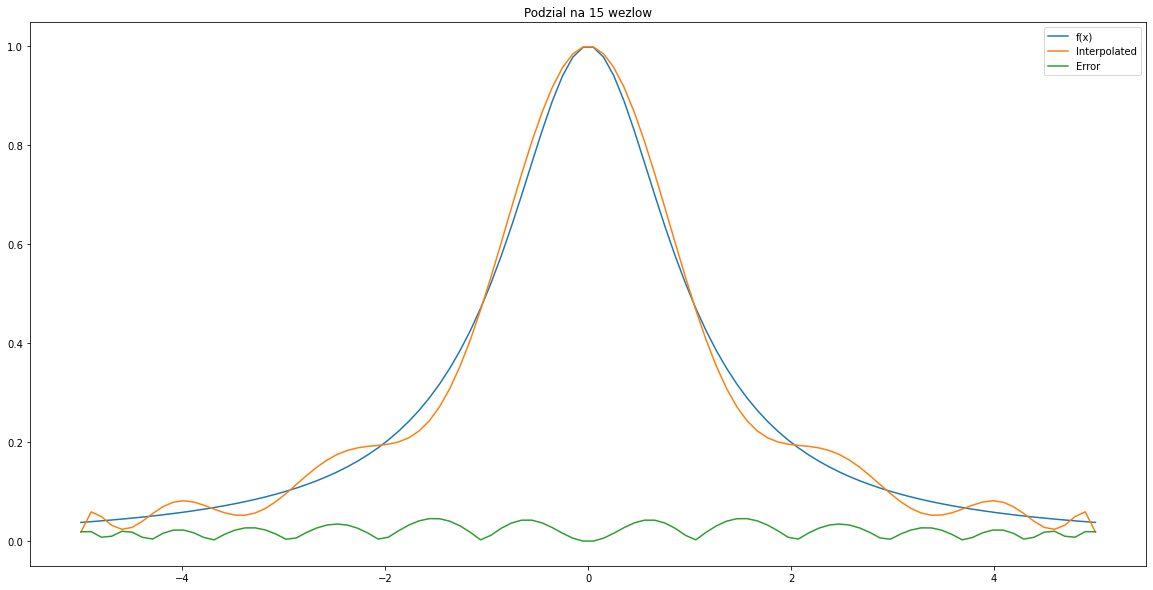

In [8]:
inter_2(15)

**Wnioski**: Interpolacja w węzłach Czebyszewa pozwala osiągnąć większą dokładność, a także zminimalizować efekt Rungego. Punkty interpolacji koncentrują się bardziej na krańcach przedziału.

#### Zadanie 3 - Interpolacja krzywych funkcjami sklejanymi
##### Algorytm na podstawie książki D. Kincaid'a oraz W. Cheney'a - rodział 9.2 'Natural Cubic Splines'

In [9]:
a = 3
b = 5

# x = a cos(t)
def f_x(t):
    return a * cos(t)

# y = b sin(t)
def f2_x(t):
    return b * sin(t)

def h(i, t):
    return t[i+1] - t[i]

# calculates vector 'z' using gaussian elimination without pivoting
def spline3_coef(n, t, y):
    h = [0] * (n-1)
    b = [0] * (n-1)
    u = [0] * (n-1)
    v = [0] * (n-1)
    z = [0] * n

    for i in range(0, n-1):
        h[i] = t[i+1] - t[i]
        b[i] = (y[i+1] - y[i])/h[i]

    u[1] = 2 * (h[0] + h[1])
    v[1] = 6 * (b[1] - b[0])

    for i in range(2, n-1):
        u[i] = (2 * (h[i] + h[i-1])) - ((h[i-1] ** 2) / u[i-1])
        v[i] = (6 * (b[i] - b[i-1])) - ((h[i-1] * v[i-1])/u[i-1])

    z[n-1] = 0
    # 3 hours here, plots looks pretty normally, but I knew something was wrong with first interval
    # for i in range(n-2, 1, -1):
    for i in range(n-2, 0, -1):
        z[i] = (v[i] - (h[i] * z[i+1]))/u[i]
    z[0] = 0

    return z

# calculates value of spline at given point - decides which spline to choose 
def spline3_eval(n, t, y, z, x):
    i = 0
    for id in range(n-2, 0, -1):
        if x - t[id] >= 0:
            i = id
            break

    h = t[i+1] - t[i]
    tmp = (z[i] / 2) + ((x - t[i]) * (z[i+1] - z[i]) / (6 * h))
    tmp = -((h/6) * (z[i+1] + (2 * z[i]))) + ((y[i+1] - y[i])/h) + ((x-t[i]) * tmp)
    return y[i] + ((x-t[i]) * tmp)

In [10]:
def draw_plot():
    plt.ylim(top=(max(a,b) + 0.1))      # for readability
    plt.ylim(bottom=-(max(a,b) + 0.1))  # for readability
    plt.show()

# used for drawing whole spline plot
# i - which spline
# z - z vec (see above)
# (t, y) - (argument, value)
# x - for this point we want to calculate spline value
def spline_value(i, z, t, y, x):
    p3 = (z[i+1] / (6 * h(i, t))) * ((x - t[i]) ** 3)
    p2 = (z[i] / (6 * h(i, t))) * ((t[i+1] - x) ** 3)
    p1 = ((y[i+1]/h(i, t)) - ((h(i, t) * z[i+1])/6)) * (x - t[i])
    p0 = ((y[i]/h(i, t)) - ((h(i, t) * z[i])/6)) * (t[i+1] - x)

    return p3 + p2 + p1 + p0


# draw spline plot
# index - spline index
# (xs, ys) - (argument, value)
def draw_spline(index, z, xs, ys):
    den_x = np.linspace(xs[0], xs[len(xs)-1], 200) # smoothing the chart
    spline_values = [spline_value(index, z, xs, ys, x) for x in den_x]
    plt.plot(den_x, spline_values, ls=':')
    

# draws all of splines
def draw_splines(z, t, vals):
    for i in range(0, points - 1):
        draw_spline(i, z, t, vals)
        
        
# draws smooth interpolated func
def draw_interpolated(points, t, values, z):
    plt.plot(t, values, 'o', c='red')  # dots at ends of intervals
    den_x = np.linspace(t[0], t[len(t)-1], 200)         # draw using multiple points (but we use only 10 splines)
    interpolated_x_values = [spline3_eval(points, t, values, z, x) for x in den_x]
    interpolated, = plt.plot(den_x, interpolated_x_values, label='Interpolated', c='black')
    plt.legend(handles=[interpolated])

In [11]:
points = 10                                 # there will be 10 splines
t = np.linspace(0, 2 * pi, points)

x_points = [f_x(x) for x in t]              # sample f(x) 
z_x = spline3_coef(points, t, x_points)     # calc z vec

y_points = [f2_x(x) for x in t]
z_y = spline3_coef(points, t, y_points)

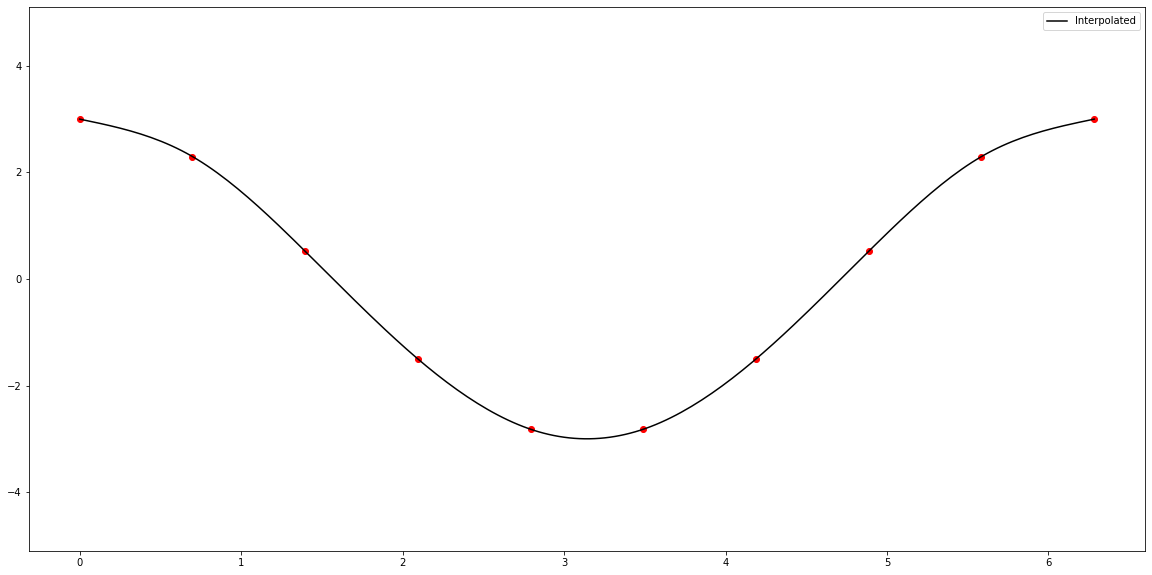

In [12]:
# show result of interpolation and the original func
draw_interpolated(points, t, x_points, z_x)
draw_plot()

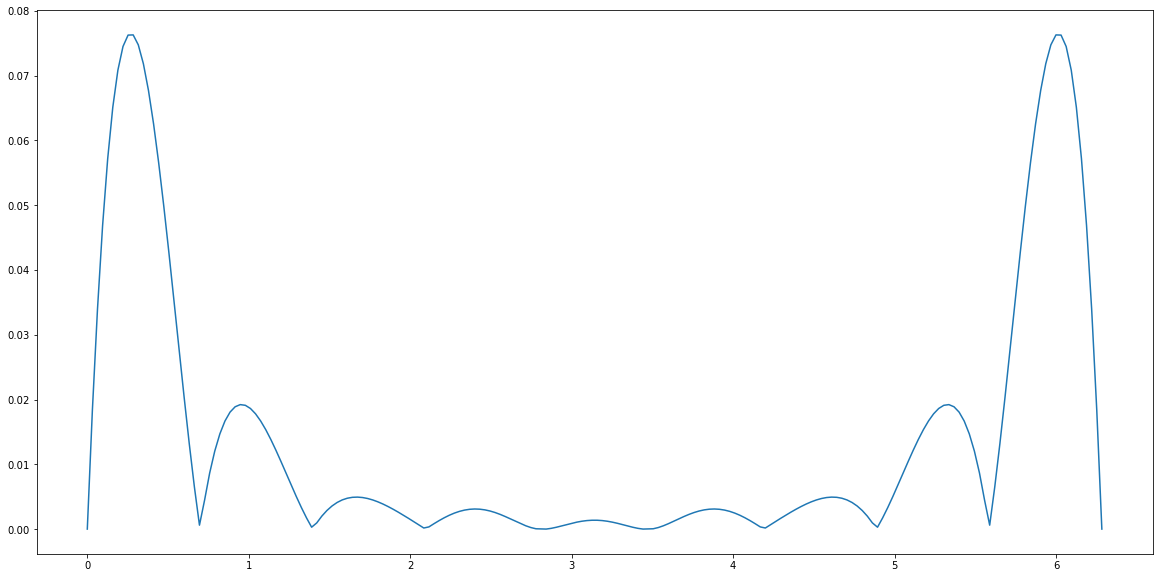

In [13]:
# show error
original_x = np.linspace(0, 2 * pi, 200)
err = [abs(f_x(x) - spline3_eval(points, t, x_points, z_x, x)) for x in original_x]
plt.plot(original_x, err)
plt.show()

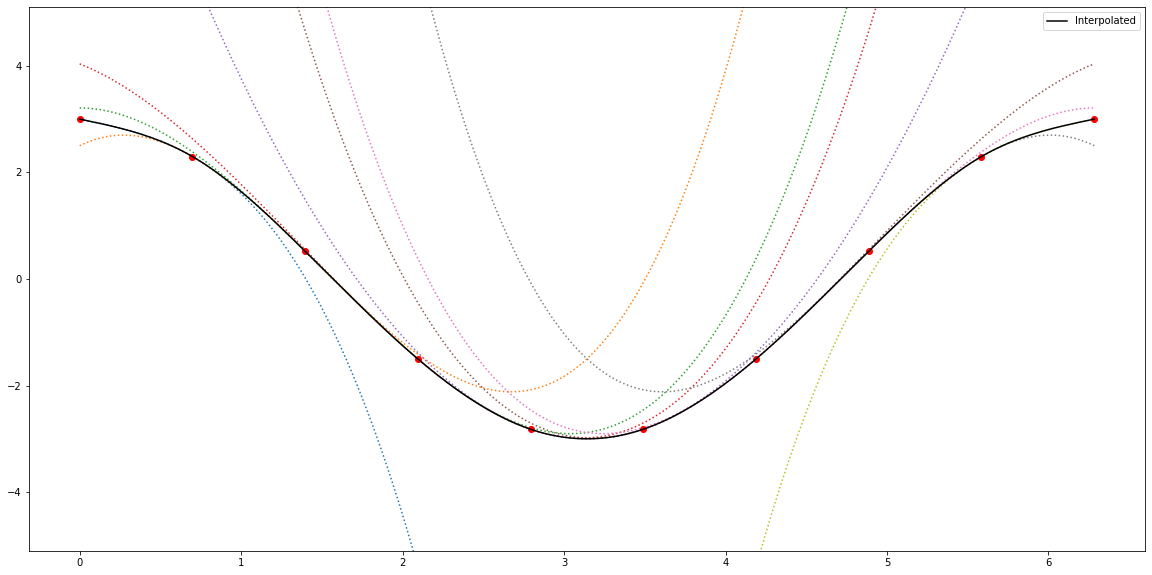

In [14]:
# show result of interpolation + draw all splines
draw_splines(z_x, t, x_points)
draw_interpolated(points, t, x_points, z_x)
draw_plot()

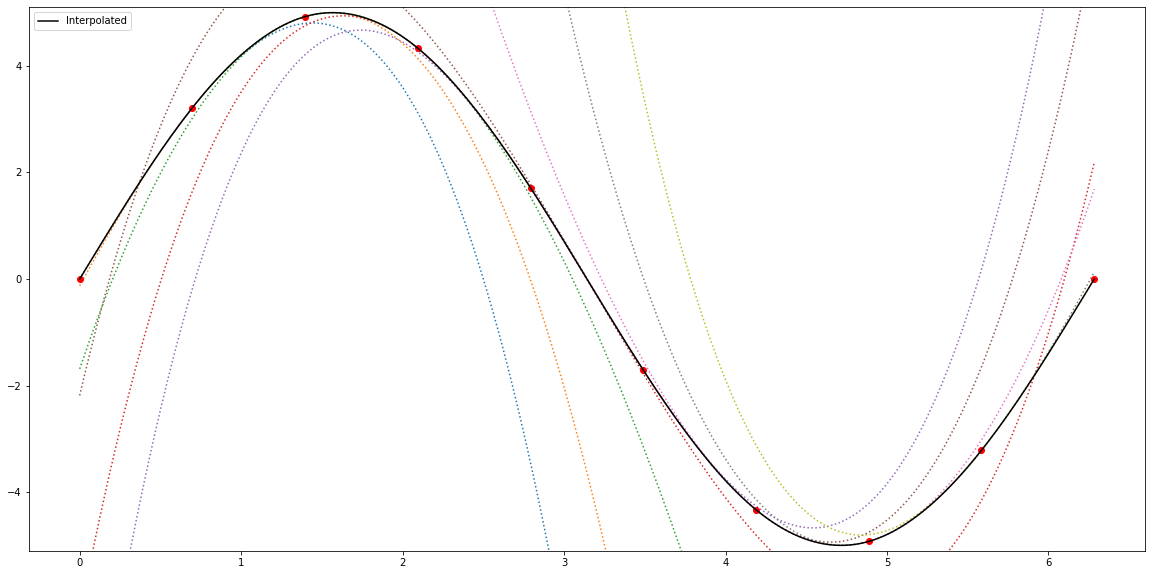

In [15]:
# same for second function
draw_splines(z_y, t, y_points)
draw_interpolated(points, t, y_points, z_y)
draw_plot()

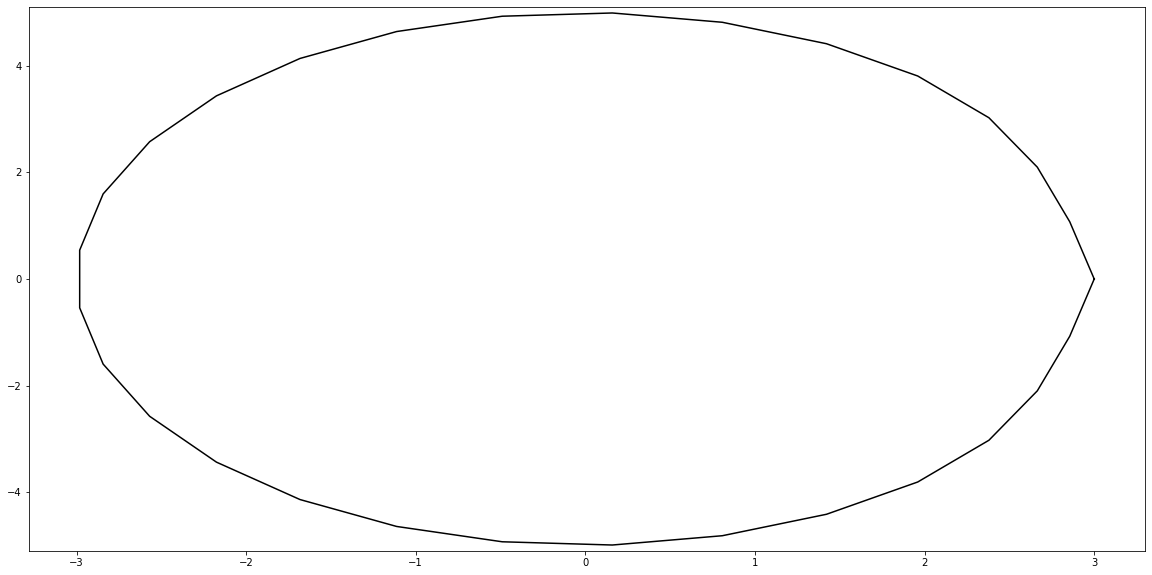

In [16]:
den_x = np.linspace(0, 2 * pi, 30)
interpolated_x_values = [spline3_eval(points, t, x_points, z_x, x) for x in den_x]
interpolated_y_values = [spline3_eval(points, t, y_points, z_y, x) for x in den_x]
plt.plot(interpolated_x_values, interpolated_y_values, c='black')
draw_plot()

**Wnioski**: Warto zauważyć, że skrajny punkt po prawej (3, 0) nie jest tak 'gładki' jak pozostałe złączenia. Może to być spowodowane założeniem warunków brzegowych przy wyliczaniu wektora z (z[0] = 0 oraz z[n-1] = 0) lub po prostu może to wynikać z tego, iż był to startowy punkt, od którego zaczęło się rysowanie. Można też stwierdzić, że interpolacja tego typu przynosi bardzo dobre efekty, a zinterpolowana funkcja bardzo przypomina funkcję interpolowaną (najwyższy błąd przybliżenia wartości nie przekroczył 0.1, a najmniejszy miał wartość mniejszą niż 0.01.